<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to show you how you can create a simple, end-to-end, state-of-the-art time series classification model using the great **fastai-v2** library in 5 steps:
1. Import libraries
2. Prepare data
3. Build learner
4. Train model
5. Inference (predictions) on additional data

In general, there are 3 main ways to classify time series, based on the input to the neural network:

- raw data

- image data (encoded from raw data)

- feature data (extracted from raw data)

In this notebook, we will use the first approach.

## Import libraries 📚

In [ ]:
stable = True # True: latest version, False: stable version
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if stable: 
        !pip install tsai -Uqq
    else:
        !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

In [ ]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.4
fastcore   : 1.3.20
torch      : 1.9.0+cu102


epoch,train_loss,valid_loss,accuracy,time
0,1.794753,1.745310,0.272222,00:00
1,1.440226,1.722800,0.433333,00:00
2,1.137173,1.689887,0.594444,00:00
3,0.944498,1.650889,0.605556,00:00
4,0.823124,1.616450,0.594444,00:00


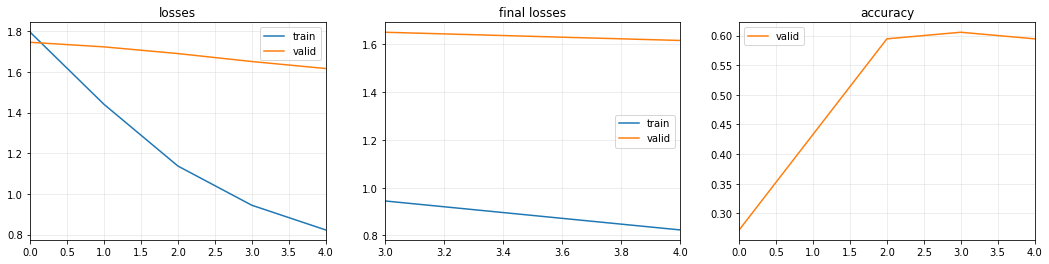

In [ ]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTimePlus(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(5, lr_max=1e-3)
learn.plot_metrics()

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.integration import FastAIPruningCallback

num_epochs = 5
num_optuna_trials = 100
    
def objective(trial:optuna.Trial):
    # Define search space here. Supported search space are 
    num_filters = trial.suggest_categorical('num_filters', [32, 64, 96, 128]) 
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)

    model = InceptionTimePlus(dls.vars, dls.c, nf=num_filters, fc_dropout=dropout_rate)
    learn = Learner(dls, model, metrics=accuracy, cbs=FastAIPruningCallback(trial))
    learn.fit_one_cycle(num_epochs, lr_max=1e-3)
            
    # return the valid_loss - learn.recorder.values returns [[train_loss, valid_loss, acc]]
    return learn.recorder.values[-1][1]

In [ ]:
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=num_optuna_trials, show_progress_bar=True)

[I 2021-06-28 10:55:19,057] A new study created in memory with name: no-name-f0d10bc1-3792-4788-adb4-46e0bc029c01
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



epoch,train_loss,valid_loss,accuracy,time
0,1.800478,1.786033,0.172222,00:00
1,1.226412,1.663307,0.355556,00:00
2,0.956675,1.438021,0.688889,00:00
3,0.796325,1.210551,0.677778,00:00
4,0.702387,1.073556,0.694444,00:00


[I 2021-06-28 10:55:19,979] Trial 0 finished with value: 1.073555588722229 and parameters: {'num_filters': 128, 'dropout_rate': 0.7646212592980608}. Best is trial 0 with value: 1.073555588722229.


epoch,train_loss,valid_loss,accuracy,time
0,1.752612,1.773570,0.166667,00:00
1,1.343642,1.726397,0.194444,00:00
2,1.049794,1.652942,0.250000,00:00
3,0.897197,1.571491,0.516667,00:00
4,0.792368,1.499526,0.550000,00:00


[I 2021-06-28 10:55:20,441] Trial 1 finished with value: 1.4995259046554565 and parameters: {'num_filters': 64, 'dropout_rate': 0.7035811162905717}. Best is trial 0 with value: 1.073555588722229.


epoch,train_loss,valid_loss,accuracy,time
0,2.220151,1.765638,0.166667,00:00
1,1.625389,1.692442,0.216667,00:00
2,1.244251,1.572811,0.538889,00:00
3,1.018535,1.433046,0.600000,00:00
4,0.893475,1.329089,0.638889,00:00


[I 2021-06-28 10:55:21,043] Trial 2 finished with value: 1.329088807106018 and parameters: {'num_filters': 96, 'dropout_rate': 0.8652243988904392}. Best is trial 0 with value: 1.073555588722229.


epoch,train_loss,valid_loss,accuracy,time
0,1.694831,1.796374,0.272222,00:00
1,1.062620,1.614833,0.483333,00:00
2,0.853650,1.300927,0.677778,00:00
3,0.704597,1.088744,0.655556,00:00
4,0.620550,0.987704,0.661111,00:00


[I 2021-06-28 10:55:21,835] Trial 3 finished with value: 0.9877035617828369 and parameters: {'num_filters': 128, 'dropout_rate': 0.04239341092084248}. Best is trial 3 with value: 0.9877035617828369.


epoch,train_loss,valid_loss,accuracy,time
0,1.922078,1.792625,0.166667,00:00
1,1.427652,1.728327,0.166667,00:00


[I 2021-06-28 10:55:22,063] Trial 4 finished with value: 1.7283270359039307 and parameters: {'num_filters': 64, 'dropout_rate': 0.7523791658226362}. Best is trial 3 with value: 0.9877035617828369.


epoch,train_loss,valid_loss,accuracy,time
0,2.330559,1.807300,0.166667,00:00
1,1.923390,1.768402,0.166667,00:00
2,1.646435,1.711085,0.266667,00:00
3,1.421831,1.641648,0.494444,00:00


[I 2021-06-28 10:55:22,456] Trial 5 finished with value: 1.6416478157043457 and parameters: {'num_filters': 64, 'dropout_rate': 0.9061056051995258}. Best is trial 3 with value: 0.9877035617828369.


epoch,train_loss,valid_loss,accuracy,time
0,4.776451,1.795418,0.172222,00:00
1,4.509996,1.789255,0.161111,00:00


[I 2021-06-28 10:55:22,665] Trial 6 finished with value: 1.7892552614212036 and parameters: {'num_filters': 32, 'dropout_rate': 0.9922735673591511}. Best is trial 3 with value: 0.9877035617828369.


epoch,train_loss,valid_loss,accuracy,time
0,1.628905,1.772325,0.172222,00:00
1,1.079956,1.606253,0.738889,00:00
2,0.815698,1.305248,0.761111,00:00
3,0.677187,1.013714,0.744444,00:00
4,0.589729,0.884098,0.722222,00:00


[I 2021-06-28 10:55:23,484] Trial 7 finished with value: 0.8840976357460022 and parameters: {'num_filters': 128, 'dropout_rate': 0.2987244386255986}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.740551,1.756181,0.211111,00:00
1,1.227645,1.702603,0.211111,00:00


[I 2021-06-28 10:55:23,717] Trial 8 finished with value: 1.7026034593582153 and parameters: {'num_filters': 64, 'dropout_rate': 0.262631679347368}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.756114,1.799475,0.205556,00:00
1,1.482718,1.769109,0.300000,00:00


[I 2021-06-28 10:55:23,930] Trial 9 finished with value: 1.769108533859253 and parameters: {'num_filters': 32, 'dropout_rate': 0.2588381371405877}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.880266,1.791512,0.266667,00:00
1,1.550254,1.767771,0.333333,00:00
2,1.236404,1.734395,0.333333,00:00
3,1.026611,1.695963,0.333333,00:00


[I 2021-06-28 10:55:24,305] Trial 10 finished with value: 1.6959633827209473 and parameters: {'num_filters': 32, 'dropout_rate': 0.20120157679832917}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.821637,1.789863,0.166667,00:00
1,1.503115,1.763055,0.166667,00:00


[I 2021-06-28 10:55:24,528] Trial 11 finished with value: 1.763055443763733 and parameters: {'num_filters': 32, 'dropout_rate': 0.3810994142914289}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.805503,1.791134,0.288889,00:00
1,1.227716,1.678103,0.416667,00:00
2,0.942717,1.435827,0.588889,00:00
3,0.779904,1.111816,0.733333,00:00


[I 2021-06-28 10:55:25,193] Trial 12 finished with value: 1.1118156909942627 and parameters: {'num_filters': 128, 'dropout_rate': 0.7428065015649109}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.829844,1.786295,0.166667,00:00
1,1.592025,1.765656,0.177778,00:00


[I 2021-06-28 10:55:25,411] Trial 13 finished with value: 1.7656563520431519 and parameters: {'num_filters': 32, 'dropout_rate': 0.7022514545626871}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.602541,1.766659,0.327778,00:00
1,1.056941,1.628158,0.516667,00:00
2,0.877802,1.405849,0.622222,00:00
3,0.738601,1.131173,0.666667,00:00


[I 2021-06-28 10:55:26,086] Trial 14 finished with value: 1.13117253780365 and parameters: {'num_filters': 128, 'dropout_rate': 0.26293074628520186}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.723275,1.784016,0.166667,00:00
1,1.159521,1.666610,0.416667,00:00
2,0.900161,1.503075,0.683333,00:00
3,0.762217,1.325732,0.655556,00:00


[I 2021-06-28 10:55:26,599] Trial 15 finished with value: 1.325731873512268 and parameters: {'num_filters': 96, 'dropout_rate': 0.034701136784620945}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.920378,1.801753,0.022222,00:00
1,1.635386,1.774580,0.211111,00:00
2,1.360705,1.737423,0.255556,00:00
3,1.152108,1.695971,0.277778,00:00


[I 2021-06-28 10:55:26,987] Trial 16 finished with value: 1.6959705352783203 and parameters: {'num_filters': 32, 'dropout_rate': 0.6909673493081329}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.846114,1.807106,0.077778,00:00
1,1.208866,1.688653,0.350000,00:00
2,0.921101,1.537387,0.544444,00:00
3,0.759371,1.349540,0.650000,00:00


[I 2021-06-28 10:55:27,495] Trial 17 finished with value: 1.3495396375656128 and parameters: {'num_filters': 96, 'dropout_rate': 0.42506168889076434}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.615429,1.759435,0.244444,00:00
1,1.125125,1.699308,0.316667,00:00
2,0.851002,1.618598,0.405556,00:00
3,0.693131,1.515469,0.505556,00:00


[I 2021-06-28 10:55:27,907] Trial 18 finished with value: 1.5154690742492676 and parameters: {'num_filters': 64, 'dropout_rate': 0.003704191935059775}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.650519,1.741508,0.216667,00:00
1,1.148463,1.610252,0.422222,00:00
2,0.916348,1.312612,0.644444,00:00
3,0.751113,1.060856,0.700000,00:00


[I 2021-06-28 10:55:28,576] Trial 19 finished with value: 1.0608559846878052 and parameters: {'num_filters': 128, 'dropout_rate': 0.49933955971232247}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,2.211811,1.832274,0.172222,00:00
1,1.973971,1.808917,0.200000,00:00
2,1.708967,1.778508,0.238889,00:00
3,1.504091,1.744986,0.261111,00:00


[I 2021-06-28 10:55:28,989] Trial 20 finished with value: 1.744985818862915 and parameters: {'num_filters': 32, 'dropout_rate': 0.8783558534474502}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.758803,1.771438,0.277778,00:00
1,1.126687,1.634884,0.688889,00:00
2,0.864062,1.366783,0.750000,00:00
3,0.693783,1.068082,0.772222,00:00
4,0.608509,0.925157,0.772222,00:00


[I 2021-06-28 10:55:29,818] Trial 21 finished with value: 0.9251570701599121 and parameters: {'num_filters': 128, 'dropout_rate': 0.7377337288164757}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.677041,1.737888,0.450000,00:00
1,1.092576,1.614155,0.583333,00:00
2,0.844673,1.370800,0.683333,00:00
3,0.699798,1.186332,0.661111,00:00


[I 2021-06-28 10:55:30,502] Trial 22 finished with value: 1.186332106590271 and parameters: {'num_filters': 128, 'dropout_rate': 0.6338479276777095}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.632209,1.768187,0.183333,00:00
1,1.051953,1.629632,0.483333,00:00
2,0.885617,1.421591,0.550000,00:00
3,0.738743,1.240102,0.611111,00:00


[I 2021-06-28 10:55:31,185] Trial 23 finished with value: 1.240101933479309 and parameters: {'num_filters': 128, 'dropout_rate': 0.5001044791270965}. Best is trial 7 with value: 0.8840976357460022.


epoch,train_loss,valid_loss,accuracy,time
0,1.580851,1.777080,0.166667,00:00
1,0.982344,1.616724,0.455556,00:00
2,0.765159,1.292757,0.616667,00:00
3,0.625236,0.987399,0.750000,00:00
4,0.550319,0.837012,0.777778,00:00


[I 2021-06-28 10:55:32,014] Trial 24 finished with value: 0.8370118737220764 and parameters: {'num_filters': 128, 'dropout_rate': 0.018403740241706545}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.635405,1.766451,0.205556,00:00
1,1.120643,1.617090,0.616667,00:00
2,0.888154,1.297240,0.694444,00:00
3,0.744526,1.067510,0.700000,00:00
4,0.654050,0.954971,0.716667,00:00


[I 2021-06-28 10:55:32,838] Trial 25 finished with value: 0.9549708962440491 and parameters: {'num_filters': 128, 'dropout_rate': 0.011222695076686107}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.645406,1.779051,0.338889,00:00
1,1.059313,1.651273,0.411111,00:00


[I 2021-06-28 10:55:33,241] Trial 26 finished with value: 1.6512727737426758 and parameters: {'num_filters': 128, 'dropout_rate': 0.033544927179691195}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.656004,1.748846,0.372222,00:00
1,1.096331,1.666571,0.477778,00:00


[I 2021-06-28 10:55:33,545] Trial 27 finished with value: 1.6665713787078857 and parameters: {'num_filters': 96, 'dropout_rate': 0.1517968328520247}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.628055,1.764301,0.166667,00:00
1,1.027272,1.601397,0.700000,00:00
2,0.795517,1.296411,0.677778,00:00
3,0.667028,1.040108,0.661111,00:00


[I 2021-06-28 10:55:34,233] Trial 28 finished with value: 1.040108323097229 and parameters: {'num_filters': 128, 'dropout_rate': 0.1256137726231223}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.667171,1.798637,0.166667,00:00
1,1.086926,1.665904,0.361111,00:00


[I 2021-06-28 10:55:34,635] Trial 29 finished with value: 1.6659036874771118 and parameters: {'num_filters': 128, 'dropout_rate': 0.34196513180954896}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.693480,1.764464,0.094444,00:00
1,1.170812,1.639645,0.533333,00:00
2,0.903897,1.448462,0.600000,00:00
3,0.756922,1.243293,0.638889,00:00


[I 2021-06-28 10:55:35,331] Trial 30 finished with value: 1.2432934045791626 and parameters: {'num_filters': 128, 'dropout_rate': 0.6608606436078479}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.684514,1.763443,0.172222,00:00
1,1.120071,1.622891,0.388889,00:00
2,0.927931,1.388715,0.572222,00:00
3,0.769831,1.053200,0.744444,00:00
4,0.664983,0.887702,0.755556,00:00


[I 2021-06-28 10:55:36,156] Trial 31 finished with value: 0.8877023458480835 and parameters: {'num_filters': 128, 'dropout_rate': 0.48223957073605356}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.658607,1.762860,0.272222,00:00
1,1.122964,1.614328,0.666667,00:00
2,0.851714,1.340030,0.705556,00:00
3,0.720642,1.008500,0.761111,00:00
4,0.611109,0.853412,0.761111,00:00


[I 2021-06-28 10:55:36,996] Trial 32 finished with value: 0.8534117937088013 and parameters: {'num_filters': 128, 'dropout_rate': 0.442753426590299}. Best is trial 24 with value: 0.8370118737220764.


epoch,train_loss,valid_loss,accuracy,time
0,1.587226,1.772232,0.322222,00:00
1,1.038741,1.626058,0.516667,00:00
2,0.795285,1.265002,0.850000,00:00
3,0.686607,0.906822,0.777778,00:00
4,0.589858,0.794149,0.744444,00:00


[I 2021-06-28 10:55:37,827] Trial 33 finished with value: 0.7941492795944214 and parameters: {'num_filters': 128, 'dropout_rate': 0.15494600366782216}. Best is trial 33 with value: 0.7941492795944214.


epoch,train_loss,valid_loss,accuracy,time
0,1.691114,1.769341,0.266667,00:00
1,1.108377,1.649083,0.627778,00:00
2,0.865491,1.510950,0.516667,00:00
3,0.759223,1.253781,0.583333,00:00


[I 2021-06-28 10:55:38,536] Trial 34 finished with value: 1.2537810802459717 and parameters: {'num_filters': 128, 'dropout_rate': 0.45972462193367936}. Best is trial 33 with value: 0.7941492795944214.


epoch,train_loss,valid_loss,accuracy,time
0,1.699971,1.773380,0.166667,00:00
1,1.171641,1.613315,0.705556,00:00
2,0.904064,1.355265,0.705556,00:00
3,0.743948,1.113380,0.677778,00:00


[I 2021-06-28 10:55:39,236] Trial 35 finished with value: 1.1133795976638794 and parameters: {'num_filters': 128, 'dropout_rate': 0.29401695661329363}. Best is trial 33 with value: 0.7941492795944214.


epoch,train_loss,valid_loss,accuracy,time
0,1.722318,1.787944,0.133333,00:00
1,1.094994,1.695342,0.316667,00:00


[I 2021-06-28 10:55:39,539] Trial 36 finished with value: 1.6953421831130981 and parameters: {'num_filters': 96, 'dropout_rate': 0.002578055072011254}. Best is trial 33 with value: 0.7941492795944214.


epoch,train_loss,valid_loss,accuracy,time
0,1.621868,1.773191,0.211111,00:00
1,1.058354,1.615342,0.427778,00:00
2,0.819784,1.299558,0.700000,00:00
3,0.668180,1.049828,0.661111,00:00


[I 2021-06-28 10:55:40,222] Trial 37 finished with value: 1.0498279333114624 and parameters: {'num_filters': 128, 'dropout_rate': 0.12858996505793613}. Best is trial 33 with value: 0.7941492795944214.


epoch,train_loss,valid_loss,accuracy,time
0,1.622554,1.776170,0.166667,00:00
1,1.150541,1.615034,0.455556,00:00
2,0.881910,1.258532,0.772222,00:00
3,0.717671,0.888947,0.783333,00:00
4,0.616460,0.761431,0.794444,00:00


[I 2021-06-28 10:55:41,067] Trial 38 finished with value: 0.7614313960075378 and parameters: {'num_filters': 128, 'dropout_rate': 0.21178848103083542}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.553312,1.748740,0.388889,00:00
1,1.034556,1.638763,0.522222,00:00


[I 2021-06-28 10:55:41,472] Trial 39 finished with value: 1.6387630701065063 and parameters: {'num_filters': 128, 'dropout_rate': 0.17487637612988685}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.554047,1.771311,0.261111,00:00
1,1.000222,1.650978,0.594444,00:00


[I 2021-06-28 10:55:41,876] Trial 40 finished with value: 1.650977611541748 and parameters: {'num_filters': 128, 'dropout_rate': 0.006560544444008276}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.670002,1.796322,0.172222,00:00
1,1.065608,1.653128,0.544444,00:00


[I 2021-06-28 10:55:42,278] Trial 41 finished with value: 1.6531280279159546 and parameters: {'num_filters': 128, 'dropout_rate': 0.4786257059211386}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.880929,1.788354,0.166667,00:00
1,1.350615,1.744694,0.166667,00:00
2,1.053706,1.675414,0.416667,00:00
3,0.864062,1.602990,0.511111,00:00


[I 2021-06-28 10:55:42,726] Trial 42 finished with value: 1.602989673614502 and parameters: {'num_filters': 64, 'dropout_rate': 0.5291700160730624}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.656844,1.760657,0.233333,00:00
1,1.178128,1.653404,0.394444,00:00


[I 2021-06-28 10:55:43,126] Trial 43 finished with value: 1.6534035205841064 and parameters: {'num_filters': 128, 'dropout_rate': 0.21438075265421486}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.633669,1.764595,0.361111,00:00
1,1.079965,1.650275,0.672222,00:00
2,0.827483,1.462739,0.700000,00:00
3,0.671526,1.319551,0.650000,00:00


[I 2021-06-28 10:55:43,672] Trial 44 finished with value: 1.31955087184906 and parameters: {'num_filters': 96, 'dropout_rate': 0.3483580411635356}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.691206,1.790993,0.222222,00:00
1,1.081841,1.622231,0.655556,00:00
2,0.879332,1.285901,0.722222,00:00
3,0.727819,1.033405,0.672222,00:00


[I 2021-06-28 10:55:44,382] Trial 45 finished with value: 1.0334053039550781 and parameters: {'num_filters': 128, 'dropout_rate': 0.07991920313058634}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.770945,1.786590,0.211111,00:00
1,1.192171,1.643231,0.577778,00:00
2,0.950435,1.320122,0.677778,00:00
3,0.769774,0.936254,0.811111,00:00
4,0.660722,0.768097,0.822222,00:00


[I 2021-06-28 10:55:45,230] Trial 46 finished with value: 0.7680965065956116 and parameters: {'num_filters': 128, 'dropout_rate': 0.5460787817359444}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.660579,1.746279,0.311111,00:00
1,1.052447,1.622807,0.438889,00:00
2,0.850653,1.425232,0.583333,00:00
3,0.712015,1.190249,0.644444,00:00


[I 2021-06-28 10:55:45,941] Trial 47 finished with value: 1.1902494430541992 and parameters: {'num_filters': 128, 'dropout_rate': 0.40934388420058276}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.626017,1.770350,0.166667,00:00
1,1.151404,1.641368,0.483333,00:00
2,0.921369,1.361918,0.772222,00:00
3,0.752812,1.077647,0.694444,00:00
4,0.668079,0.931182,0.705556,00:00


[I 2021-06-28 10:55:46,776] Trial 48 finished with value: 0.9311820268630981 and parameters: {'num_filters': 128, 'dropout_rate': 0.5706766360275015}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.631619,1.759262,0.327778,00:00
1,1.170878,1.574062,0.638889,00:00
2,0.894636,1.197711,0.711111,00:00
3,0.737598,0.912183,0.694444,00:00
4,0.642786,0.795327,0.700000,00:00


[I 2021-06-28 10:55:47,629] Trial 49 finished with value: 0.7953266501426697 and parameters: {'num_filters': 128, 'dropout_rate': 0.0928828942061999}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.704901,1.782997,0.166667,00:00
1,1.154784,1.633628,0.522222,00:00
2,0.913040,1.344808,0.694444,00:00
3,0.739803,0.996133,0.750000,00:00
4,0.638094,0.835959,0.822222,00:00


[I 2021-06-28 10:55:48,477] Trial 50 finished with value: 0.83595871925354 and parameters: {'num_filters': 128, 'dropout_rate': 0.4042563275642582}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.764211,1.785249,0.166667,00:00
1,1.210730,1.628760,0.516667,00:00
2,0.968581,1.259883,0.672222,00:00
3,0.790522,0.968528,0.677778,00:00
4,0.671466,0.870712,0.705556,00:00


[I 2021-06-28 10:55:49,331] Trial 51 finished with value: 0.8707123398780823 and parameters: {'num_filters': 128, 'dropout_rate': 0.15288248836933338}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.726859,1.810682,0.166667,00:00
1,1.142718,1.652697,0.483333,00:00
2,0.892348,1.332770,0.666667,00:00
3,0.726905,0.948193,0.816667,00:00
4,0.630959,0.782657,0.822222,00:00


[I 2021-06-28 10:55:50,196] Trial 52 finished with value: 0.7826569676399231 and parameters: {'num_filters': 128, 'dropout_rate': 0.33841990636039976}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.725922,1.782304,0.405556,00:00
1,1.206272,1.696674,0.472222,00:00


[I 2021-06-28 10:55:50,515] Trial 53 finished with value: 1.696674108505249 and parameters: {'num_filters': 96, 'dropout_rate': 0.5939956147383008}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.692313,1.785127,0.233333,00:00
1,1.237983,1.654988,0.344444,00:00
2,0.979970,1.357661,0.611111,00:00
3,0.816376,0.975821,0.666667,00:00
4,0.712459,0.820579,0.711111,00:00


[I 2021-06-28 10:55:51,385] Trial 54 finished with value: 0.8205785155296326 and parameters: {'num_filters': 128, 'dropout_rate': 0.37733051477399865}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.626516,1.796336,0.194444,00:00
1,1.004835,1.648138,0.394444,00:00
2,0.793419,1.448345,0.633333,00:00
3,0.651315,1.195685,0.711111,00:00


[I 2021-06-28 10:55:52,093] Trial 55 finished with value: 1.1956850290298462 and parameters: {'num_filters': 128, 'dropout_rate': 0.1275550396196911}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.741615,1.783115,0.250000,00:00
1,1.218463,1.721318,0.338889,00:00


[I 2021-06-28 10:55:52,366] Trial 56 finished with value: 1.7213183641433716 and parameters: {'num_filters': 64, 'dropout_rate': 0.21904763741415428}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.544017,1.766034,0.288889,00:00
1,1.011781,1.642509,0.688889,00:00


[I 2021-06-28 10:55:52,782] Trial 57 finished with value: 1.642508625984192 and parameters: {'num_filters': 128, 'dropout_rate': 0.04740439011661105}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.558788,1.781992,0.322222,00:00
1,1.027455,1.621612,0.622222,00:00
2,0.792778,1.269423,0.738889,00:00
3,0.649438,0.927343,0.811111,00:00
4,0.571608,0.789714,0.783333,00:00


[I 2021-06-28 10:55:53,630] Trial 58 finished with value: 0.7897137403488159 and parameters: {'num_filters': 128, 'dropout_rate': 0.34741299787382585}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.670546,1.796550,0.300000,00:00
1,1.058378,1.656354,0.550000,00:00
2,0.831956,1.494925,0.644444,00:00
3,0.689148,1.365235,0.638889,00:00


[I 2021-06-28 10:55:54,191] Trial 59 finished with value: 1.3652347326278687 and parameters: {'num_filters': 96, 'dropout_rate': 0.3128125245399889}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.673735,1.799516,0.166667,00:00
1,1.114884,1.654516,0.355556,00:00


[I 2021-06-28 10:55:54,622] Trial 60 finished with value: 1.6545162200927734 and parameters: {'num_filters': 128, 'dropout_rate': 0.0790354463970214}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.647027,1.786846,0.188889,00:00
1,1.056768,1.644714,0.633333,00:00
2,0.879253,1.432917,0.611111,00:00
3,0.742284,1.154366,0.661111,00:00


[I 2021-06-28 10:55:55,350] Trial 61 finished with value: 1.1543660163879395 and parameters: {'num_filters': 128, 'dropout_rate': 0.5489924217077724}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,2.116380,1.810801,0.250000,00:00
1,1.771545,1.774952,0.272222,00:00
2,1.491839,1.735277,0.288889,00:00
3,1.298344,1.697162,0.338889,00:00


[I 2021-06-28 10:55:55,783] Trial 62 finished with value: 1.6971616744995117 and parameters: {'num_filters': 32, 'dropout_rate': 0.7793146164897824}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.567217,1.769430,0.205556,00:00
1,1.013310,1.609729,0.638889,00:00
2,0.792556,1.364464,0.638889,00:00
3,0.668862,1.033680,0.688889,00:00


[I 2021-06-28 10:55:56,508] Trial 63 finished with value: 1.0336796045303345 and parameters: {'num_filters': 128, 'dropout_rate': 0.10615478062636574}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,4.463837,1.799007,0.294444,00:00
1,4.417381,1.760234,0.444444,00:00


[I 2021-06-28 10:55:56,935] Trial 64 finished with value: 1.7602343559265137 and parameters: {'num_filters': 128, 'dropout_rate': 0.987635983013657}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.624603,1.768280,0.166667,00:00
1,1.020798,1.622516,0.422222,00:00
2,0.803953,1.344096,0.677778,00:00
3,0.675670,1.096211,0.650000,00:00


[I 2021-06-28 10:55:57,671] Trial 65 finished with value: 1.0962111949920654 and parameters: {'num_filters': 128, 'dropout_rate': 0.18260305695995288}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.803916,1.814940,0.155556,00:00
1,1.247723,1.752185,0.183333,00:00


[I 2021-06-28 10:55:57,953] Trial 66 finished with value: 1.7521851062774658 and parameters: {'num_filters': 64, 'dropout_rate': 0.0007248762755925411}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.769043,1.779393,0.211111,00:00
1,1.337524,1.723375,0.261111,00:00
2,1.050869,1.641057,0.316667,00:00
3,0.868455,1.538450,0.450000,00:00


[I 2021-06-28 10:55:58,438] Trial 67 finished with value: 1.538450002670288 and parameters: {'num_filters': 64, 'dropout_rate': 0.5807110048890953}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.584976,1.732100,0.244444,00:00
1,1.016612,1.587860,0.622222,00:00
2,0.837454,1.338591,0.655556,00:00
3,0.709802,1.012471,0.705556,00:00
4,0.630686,0.861333,0.677778,00:00


[I 2021-06-28 10:55:59,347] Trial 68 finished with value: 0.8613329529762268 and parameters: {'num_filters': 128, 'dropout_rate': 0.2878855974777994}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.801286,1.819046,0.000000,00:00
1,1.459737,1.790688,0.033333,00:00


[I 2021-06-28 10:55:59,633] Trial 69 finished with value: 1.7906875610351562 and parameters: {'num_filters': 32, 'dropout_rate': 0.23292187434426753}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.823333,1.808054,0.044444,00:00
1,1.289624,1.742420,0.405556,00:00


[I 2021-06-28 10:55:59,900] Trial 70 finished with value: 1.742419958114624 and parameters: {'num_filters': 64, 'dropout_rate': 0.3263093564894767}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.560822,1.749307,0.311111,00:00
1,1.087544,1.632977,0.411111,00:00
2,0.970227,1.308826,0.638889,00:00
3,0.820556,0.985150,0.677778,00:00
4,0.717837,0.867685,0.716667,00:00


[I 2021-06-28 10:56:00,754] Trial 71 finished with value: 0.8676853775978088 and parameters: {'num_filters': 128, 'dropout_rate': 0.3740169419393799}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.720593,1.788667,0.200000,00:00
1,1.144047,1.647090,0.561111,00:00
2,0.970014,1.428668,0.527778,00:00
3,0.816288,1.126848,0.633333,00:00


[I 2021-06-28 10:56:01,479] Trial 72 finished with value: 1.126847505569458 and parameters: {'num_filters': 128, 'dropout_rate': 0.23670623631482218}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.655105,1.773247,0.161111,00:00
1,1.155326,1.591135,0.661111,00:00
2,0.891784,1.220194,0.722222,00:00
3,0.731911,0.975360,0.666667,00:00
4,0.644638,0.881610,0.677778,00:00


[I 2021-06-28 10:56:02,356] Trial 73 finished with value: 0.8816104531288147 and parameters: {'num_filters': 128, 'dropout_rate': 0.3514438068213662}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.640530,1.788718,0.272222,00:00
1,1.133639,1.605869,0.644444,00:00
2,0.911619,1.211539,0.716667,00:00
3,0.746105,0.949118,0.683333,00:00
4,0.641257,0.861753,0.683333,00:00


[I 2021-06-28 10:56:03,223] Trial 74 finished with value: 0.8617526292800903 and parameters: {'num_filters': 128, 'dropout_rate': 0.07470910729279454}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.571568,1.740990,0.211111,00:00
1,1.061519,1.590505,0.683333,00:00
2,0.838125,1.323226,0.638889,00:00
3,0.713163,1.126423,0.627778,00:00


[I 2021-06-28 10:56:03,931] Trial 75 finished with value: 1.1264231204986572 and parameters: {'num_filters': 128, 'dropout_rate': 0.2782156543542096}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.607903,1.772449,0.172222,00:00
1,1.049614,1.633936,0.238889,00:00


[I 2021-06-28 10:56:04,362] Trial 76 finished with value: 1.6339360475540161 and parameters: {'num_filters': 128, 'dropout_rate': 0.1789844828401364}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.624160,1.778423,0.238889,00:00
1,1.084256,1.640919,0.622222,00:00


[I 2021-06-28 10:56:04,784] Trial 77 finished with value: 1.6409193277359009 and parameters: {'num_filters': 128, 'dropout_rate': 0.4010738461988861}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.702947,1.797769,0.166667,00:00
1,1.121152,1.641619,0.388889,00:00
2,0.846039,1.356392,0.666667,00:00
3,0.702206,1.047207,0.700000,00:00
4,0.605484,0.902510,0.722222,00:00


[I 2021-06-28 10:56:05,642] Trial 78 finished with value: 0.902510404586792 and parameters: {'num_filters': 128, 'dropout_rate': 0.18940824378024151}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.588877,1.771572,0.166667,00:00
1,1.012143,1.628189,0.400000,00:00


[I 2021-06-28 10:56:06,063] Trial 79 finished with value: 1.6281887292861938 and parameters: {'num_filters': 128, 'dropout_rate': 0.3214213315080175}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.590325,1.748747,0.261111,00:00
1,1.022454,1.623109,0.338889,00:00
2,0.797368,1.395109,0.572222,00:00
3,0.659037,1.105384,0.644444,00:00


[I 2021-06-28 10:56:06,802] Trial 80 finished with value: 1.105384111404419 and parameters: {'num_filters': 128, 'dropout_rate': 0.4991114016978167}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.643306,1.760201,0.222222,00:00
1,1.085744,1.610064,0.633333,00:00
2,0.887210,1.318661,0.711111,00:00
3,0.740588,1.026174,0.677778,00:00
4,0.644955,0.877050,0.683333,00:00


[I 2021-06-28 10:56:07,662] Trial 81 finished with value: 0.8770504593849182 and parameters: {'num_filters': 128, 'dropout_rate': 0.07315150513040641}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.612886,1.752755,0.311111,00:00
1,0.995864,1.606386,0.544444,00:00
2,0.764514,1.360907,0.727778,00:00
3,0.656458,1.136355,0.705556,00:00


[I 2021-06-28 10:56:08,386] Trial 82 finished with value: 1.1363552808761597 and parameters: {'num_filters': 128, 'dropout_rate': 0.26747834176994756}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.838161,1.762577,0.177778,00:00
1,1.525442,1.741078,0.244444,00:00


[I 2021-06-28 10:56:08,652] Trial 83 finished with value: 1.7410780191421509 and parameters: {'num_filters': 32, 'dropout_rate': 0.20943065647220244}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.745791,1.795577,0.211111,00:00
1,1.123268,1.694528,0.388889,00:00
2,0.864922,1.554350,0.577778,00:00
3,0.706491,1.390585,0.700000,00:00


[I 2021-06-28 10:56:09,199] Trial 84 finished with value: 1.3905847072601318 and parameters: {'num_filters': 96, 'dropout_rate': 0.27756480959594354}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.854133,1.811799,0.133333,00:00
1,1.532758,1.785330,0.122222,00:00
2,1.260542,1.744551,0.283333,00:00
3,1.081061,1.699571,0.505556,00:00


[I 2021-06-28 10:56:09,656] Trial 85 finished with value: 1.6995713710784912 and parameters: {'num_filters': 32, 'dropout_rate': 0.39150731457815463}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,3.245907,1.770191,0.277778,00:00
1,3.295309,1.755522,0.288889,00:00
2,3.201998,1.729890,0.377778,00:00
3,3.020600,1.697221,0.488889,00:00


[I 2021-06-28 10:56:10,129] Trial 86 finished with value: 1.697221040725708 and parameters: {'num_filters': 64, 'dropout_rate': 0.9785922845760886}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.741913,1.791210,0.166667,00:00
1,1.151849,1.661735,0.316667,00:00
2,0.894231,1.440515,0.594444,00:00
3,0.741395,1.206573,0.638889,00:00


[I 2021-06-28 10:56:10,848] Trial 87 finished with value: 1.2065727710723877 and parameters: {'num_filters': 128, 'dropout_rate': 0.6207499115067122}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.632522,1.765762,0.177778,00:00
1,1.119241,1.614488,0.588889,00:00
2,0.862550,1.291114,0.688889,00:00
3,0.734527,1.023222,0.661111,00:00
4,0.641914,0.892134,0.672222,00:00


[I 2021-06-28 10:56:11,706] Trial 88 finished with value: 0.8921335935592651 and parameters: {'num_filters': 128, 'dropout_rate': 0.4287710021936936}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.565037,1.767648,0.283333,00:00
1,1.098176,1.635413,0.472222,00:00


[I 2021-06-28 10:56:12,119] Trial 89 finished with value: 1.6354129314422607 and parameters: {'num_filters': 128, 'dropout_rate': 0.1419704077121819}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.671056,1.800869,0.150000,00:00
1,1.095635,1.663383,0.400000,00:00
2,0.892959,1.363104,0.700000,00:00
3,0.727649,1.066958,0.666667,00:00
4,0.641355,0.925971,0.683333,00:00


[I 2021-06-28 10:56:12,998] Trial 90 finished with value: 0.9259707927703857 and parameters: {'num_filters': 128, 'dropout_rate': 0.3312806311249419}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.671375,1.730672,0.311111,00:00
1,1.093718,1.609692,0.466667,00:00
2,0.863378,1.369687,0.550000,00:00
3,0.707812,1.013949,0.722222,00:00


[I 2021-06-28 10:56:13,718] Trial 91 finished with value: 1.0139485597610474 and parameters: {'num_filters': 128, 'dropout_rate': 0.3698030085827551}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.543360,1.723065,0.416667,00:00
1,1.067336,1.592198,0.627778,00:00
2,0.833126,1.308378,0.644444,00:00
3,0.715917,0.973411,0.661111,00:00
4,0.643777,0.812409,0.711111,00:00


[I 2021-06-28 10:56:14,602] Trial 92 finished with value: 0.8124092221260071 and parameters: {'num_filters': 128, 'dropout_rate': 0.24409575280368834}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.494730,1.745777,0.227778,00:00
1,0.980826,1.589071,0.627778,00:00
2,0.782570,1.325920,0.677778,00:00
3,0.670039,1.068965,0.738889,00:00


[I 2021-06-28 10:56:15,334] Trial 93 finished with value: 1.068965196609497 and parameters: {'num_filters': 128, 'dropout_rate': 0.11052649659881825}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.847249,1.796857,0.222222,00:00
1,1.236053,1.702397,0.361111,00:00


[I 2021-06-28 10:56:15,680] Trial 94 finished with value: 1.7023969888687134 and parameters: {'num_filters': 96, 'dropout_rate': 0.4548792647796515}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.567422,1.772781,0.161111,00:00
1,1.079227,1.643582,0.488889,00:00
2,0.907347,1.262500,0.672222,00:00
3,0.771888,0.888751,0.733333,00:00
4,0.667031,0.770715,0.777778,00:00


[I 2021-06-28 10:56:16,548] Trial 95 finished with value: 0.7707154750823975 and parameters: {'num_filters': 128, 'dropout_rate': 0.20791962138852413}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.625979,1.788144,0.155556,00:00
1,1.073406,1.631408,0.661111,00:00


[I 2021-06-28 10:56:16,976] Trial 96 finished with value: 1.6314079761505127 and parameters: {'num_filters': 128, 'dropout_rate': 0.06786736639679196}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.623310,1.776483,0.166667,00:00
1,1.214432,1.653115,0.583333,00:00
2,0.931041,1.360523,0.761111,00:00
3,0.788248,1.006650,0.766667,00:00
4,0.692272,0.831047,0.761111,00:00


[I 2021-06-28 10:56:17,844] Trial 97 finished with value: 0.8310474157333374 and parameters: {'num_filters': 128, 'dropout_rate': 0.21679220868218316}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.589682,1.744263,0.238889,00:00
1,1.060256,1.581389,0.572222,00:00
2,0.797981,1.314766,0.611111,00:00
3,0.675751,1.007206,0.655556,00:00
4,0.577724,0.867259,0.688889,00:00


[I 2021-06-28 10:56:18,724] Trial 98 finished with value: 0.8672585487365723 and parameters: {'num_filters': 128, 'dropout_rate': 0.04578728215931188}. Best is trial 38 with value: 0.7614313960075378.


epoch,train_loss,valid_loss,accuracy,time
0,1.598947,1.732973,0.400000,00:00
1,1.019026,1.571408,0.588889,00:00
2,0.776729,1.283739,0.716667,00:00
3,0.658807,1.017141,0.788889,00:00
4,0.566864,0.858077,0.788889,00:00


[I 2021-06-28 10:56:19,600] Trial 99 finished with value: 0.8580767512321472 and parameters: {'num_filters': 128, 'dropout_rate': 0.09634613300999048}. Best is trial 38 with value: 0.7614313960075378.



In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.7740388512611389
  Params: 
    num_filters: 128
    dropout_rate: 0.98735655761383
